<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Experiments/covid_facemask_and_social_distance/dataset_creation_bounding_box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Purpose

Notebook provide the code to generate bbox ready dataset for classification tasks, we will use already trained public classifier from detectron2 and use their predictions to generate bbox datasets.

Reason for this task is that when training certain classifiers on public datasets like below mask and if we want to use the same model to identify some other lables we will not be able to perform that task, since datasets doesnot have those bbox. 

Eg Below datasets have mask/nomask bbox, but if in order to train the model to identify person as well, we will use the predictions from pretrained classier and use thos bbox as train set

### Mount Gdrive and download datasets



*   Download kaggle json to download dataset
*   Upload the new dataset to drive


Copy the Authentication json for kaggle to download our datasets, 1 time activity

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
''' Link to explain how to download Datasets from kaggle https://www.kaggle.com/general/74235'''
!pip install -q kaggle
!mkdir ~/.kaggle
!cp '/content/drive/My Drive/Kaggle/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list

In [ ]:
%%time
!kaggle datasets download -d wobotintelligence/face-mask-detection-dataset -p dataset
!unzip dataset/face-mask-detection-dataset.zip -d dataset/face-mask-detection-dataset
!rm dataset/face-mask-detection-dataset.zip

!kaggle datasets download -d ivandanilovich/medical-masks-dataset-images-tfrecords -p dataset
!unzip dataset/medical-masks-dataset-images-tfrecords.zip -d dataset/medical-masks-dataset > /dev/null
!rm dataset/medical-masks-dataset-images-tfrecords.zip

!kaggle datasets download -d abdelaliezzyn/medical-masks -p dataset
!unzip dataset/medical-masks.zip -d dataset/medical-masks > /dev/null
!rm dataset/medical-masks.zip

CPU times: user 2.16 ms, sys: 6.39 ms, total: 8.56 ms
Wall time: 311 ms


### Installing Dependencies

In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
assert torch.__version__.startswith("1.6")
!pip install pyyaml==5.1 pycocotools>=2.0.1
!pip uninstall -y detectron2
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Uninstalling detectron2-0.2.1+cu101:
  Successfully uninstalled detectron2-0.2.1+cu101
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
  Using cached https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/detectron2-0.2.1%2Bcu101-cp36-cp36m-linux_x86_64.whl


### Lets browse out dataset

In [ ]:
dataset_1 = '/content/dataset/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations'
dataset_2 = "/content/dataset/medical-masks-dataset/medical-masks-dataset/labels"
dataset_3 = "/content/dataset/medical-masks/medical_masks/train/annotations"

In [ ]:
import os

img_files_1 = []
dataset_1_files = [os.path.join(dataset_1, x) for x in os.listdir(dataset_1)]
for dataset_1_file in dataset_1_files:
    dataset_1_img_file = dataset_1_file.replace("annotations", "images").replace(".json", "")
    if not os.path.exists(dataset_1_img_file):
        continue
    img_files_1.append(dataset_1_img_file)
print("Total image files with annotations:", len(img_files_1))

img_files_2 = []
dataset_2_files = [os.path.join(dataset_2, x) for x in os.listdir(dataset_2)]
for dataset_2_file in dataset_2_files:
    dataset_2_img_file = dataset_2_file.replace("labels", "images").replace("xml", "jpg")
    if not os.path.exists(dataset_2_img_file):
        continue
    img_files_2.append(dataset_2_img_file)
print("Total image files with annotations:", len(img_files_2))

img_files_3 = []
dataset_3_files = [os.path.join(dataset_3, x) for x in os.listdir(dataset_3)]
for dataset_3_file in dataset_3_files:
    dataset_3_img_file = dataset_3_file.replace("annotations", "images").replace("xml", "png")
    if not os.path.exists(dataset_3_img_file):
        continue
    img_files_3.append(dataset_3_img_file)
print("Total image files with annotations:", len(img_files_3))

print("=" * 50)
img_files = img_files_1 + img_files_2 + img_files_3
print("Total image files with annotations:", len(img_files))


Total image files with annotations: 4326
Total image files with annotations: 1148
Total image files with annotations: 7782
Total image files with annotations: 13256


### Loading model to be used for annotations

In [ ]:
import detectron2
import torch
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

In [ ]:
""" Download pretrained models """

## https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md

cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
model_yaml = "COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"
model_yaml = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"  # AP 44.3, infer 0.103

cfg.merge_from_file(model_zoo.get_config_file(model_yaml))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set threshold for this model
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_yaml)
predictor = DefaultPredictor(cfg)

social_model = build_model(cfg)
_ = DetectionCheckpointer(social_model).load(cfg.MODEL.WEIGHTS)

model_final_2d9806.pkl: 431MB [00:46, 9.34MB/s]                           


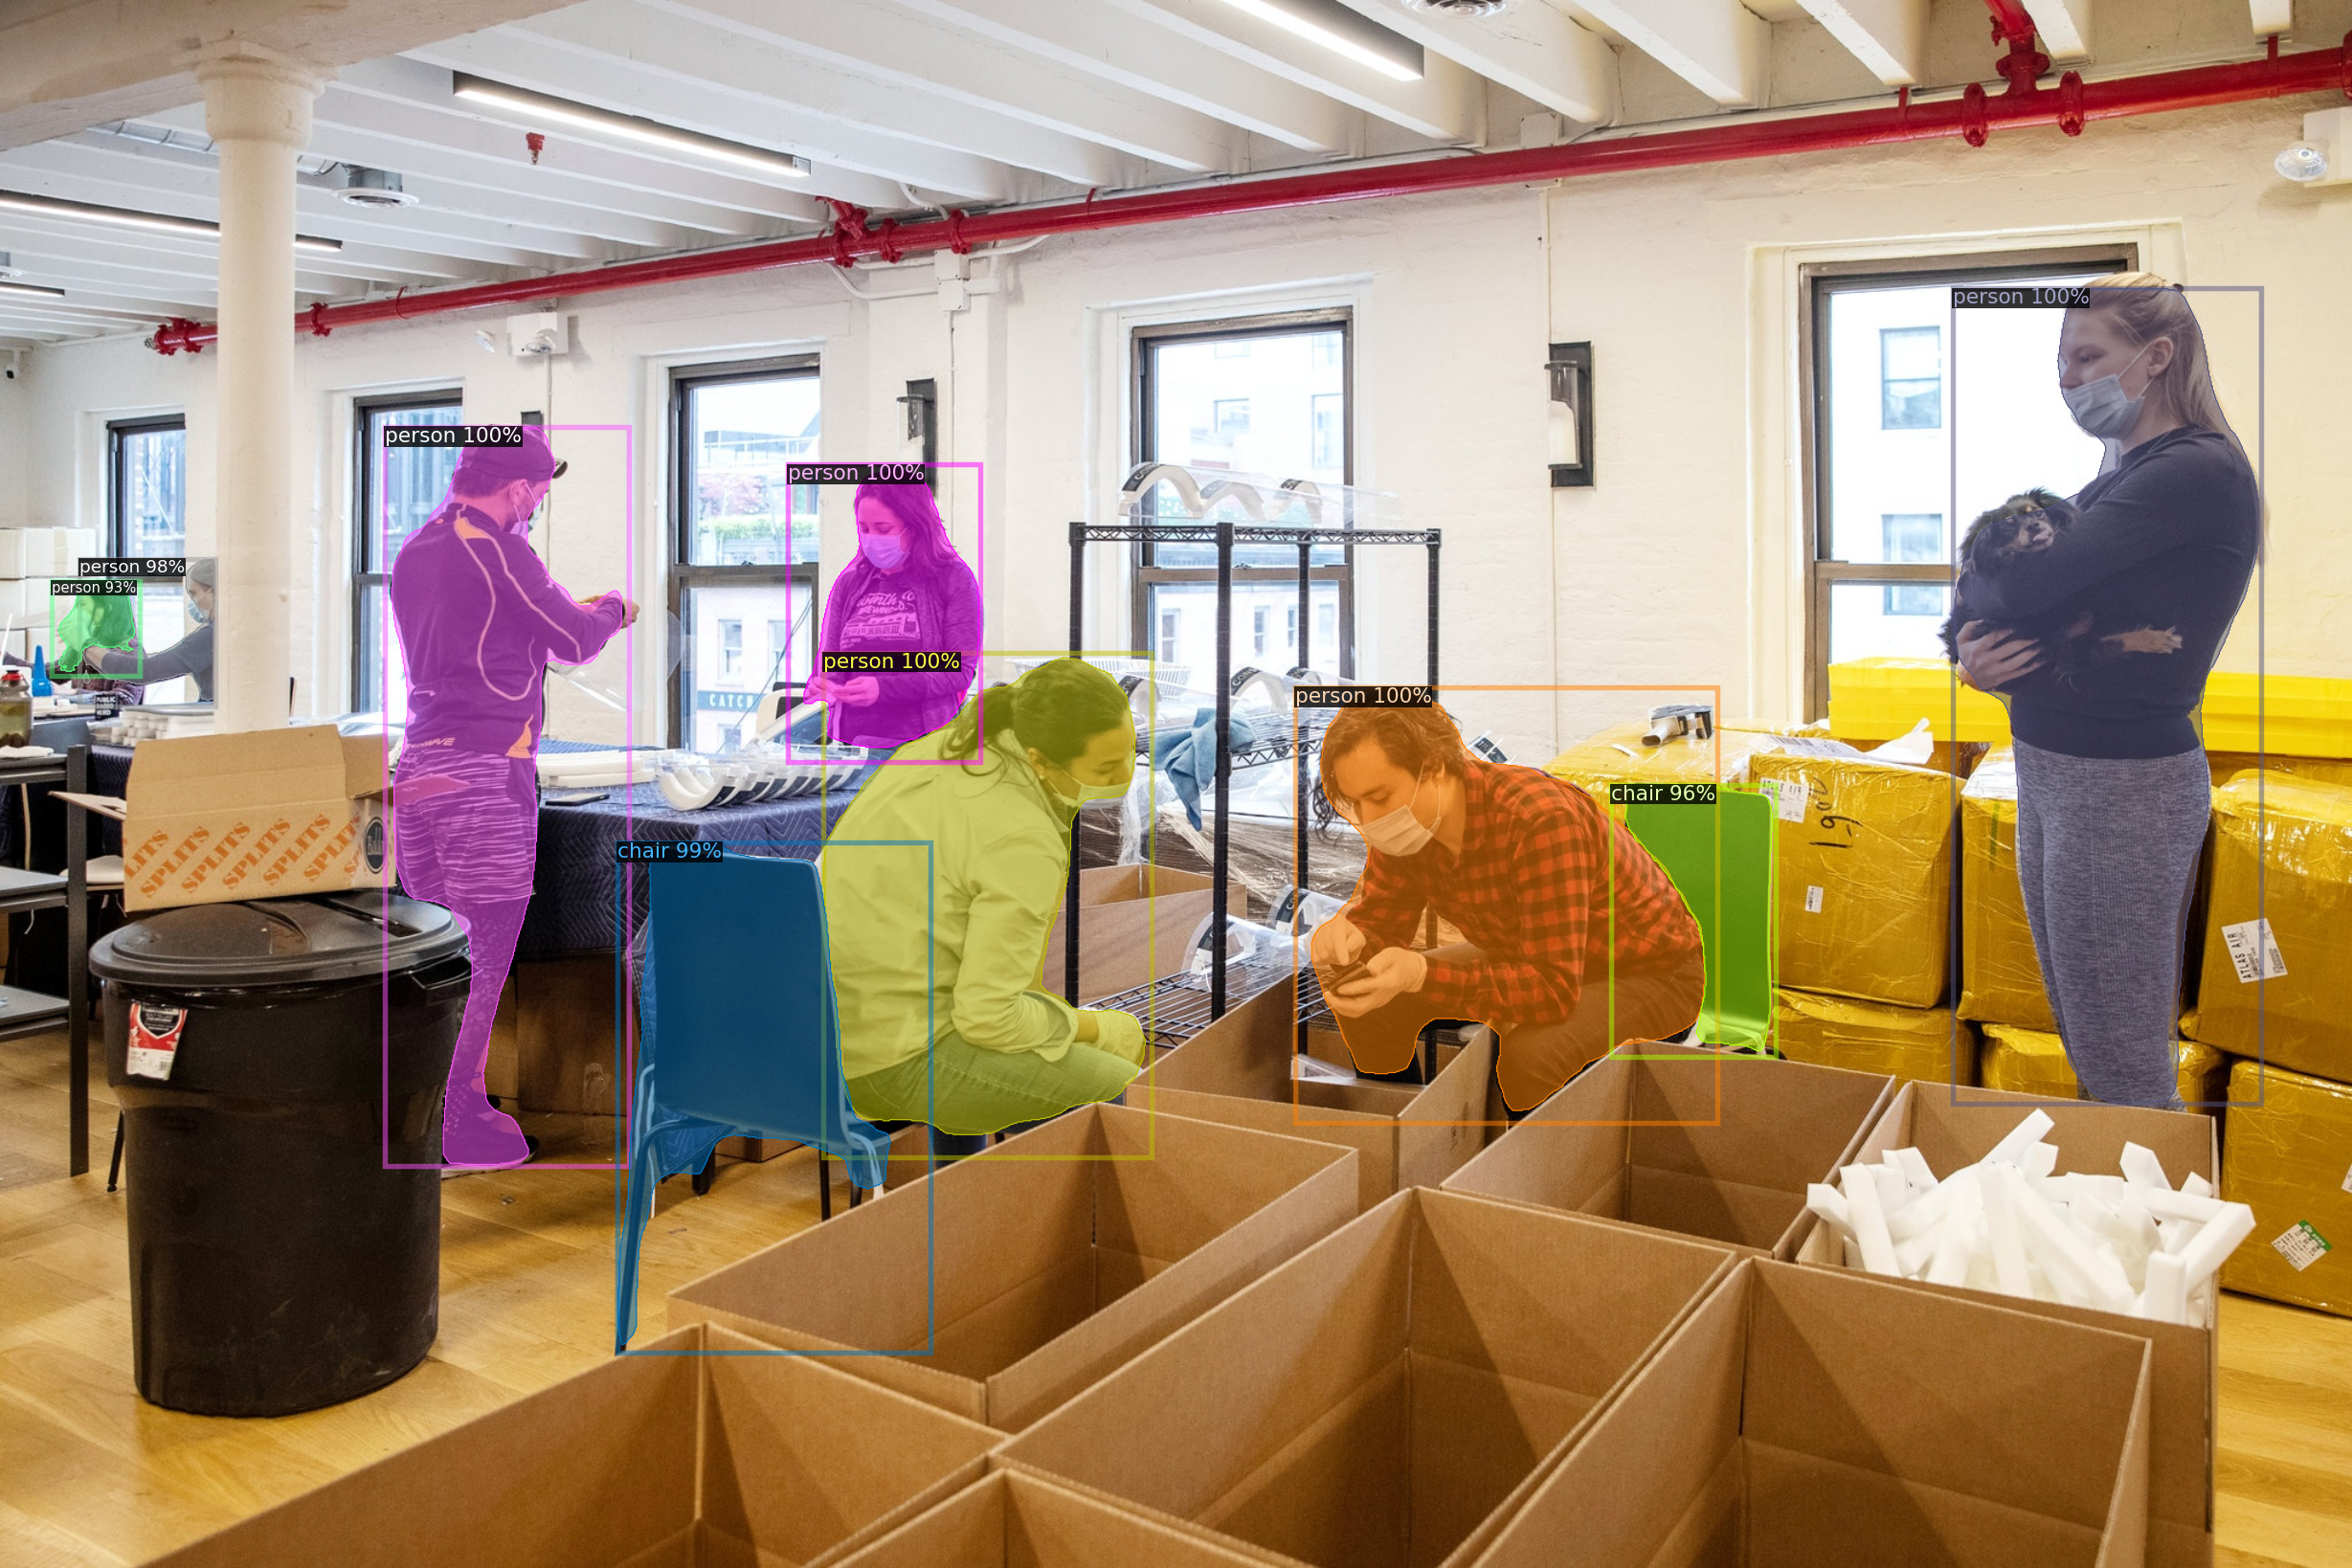

CPU times: user 2.54 s, sys: 140 ms, total: 2.68 s
Wall time: 2.61 s


In [ ]:
%%time
#read an image
img = cv2.imread(img_files[0])

#pass to the model
outputs = predictor(img)

# Use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

### Generating dataset

In [ ]:
# outputs['instances'].pred_boxes
import pandas as pd
import time
starttime = time.time()
dataframe_file = "dataset_person.pkl"
data = []
if os.path.exists(dataframe_file):
    df = pd.read_pickle(dataframe_file)
    data = df.to_dict('records')

for fileno, img_file in enumerate(img_files):
    if df[df['filepath'] == img_file].shape[0] > 0:
        # print("Already processed:", img_file)
        continue

    img = cv2.imread(img_file)
    outputs = predictor(img)

    bbox = outputs['instances'].pred_boxes.tensor.cpu().numpy()
    for i, classid in enumerate(outputs['instances'].pred_classes.cpu().numpy()):
        if classid != 0:
            continue
        d = {'filepath': img_file, 'bbox': bbox[i], 'classname': 'person'}
        data.append(d)
    
    if fileno % 100 == 0:
        df = pd.DataFrame(data)
        df.to_pickle(dataframe_file)
        timetaken = time.time() - starttime
        print("Time Elaped:", timetaken, "Processed:", fileno, "Time per image:", timetaken / fileno, df.shape)

df = pd.DataFrame(data)
df.to_pickle(dataframe_file)

timetaken = time.time() - starttime
print("Time Elaped:", timetaken, "Processed:", fileno, "Time per image:", timetaken / fileno, df.shape)
print("Total unique files:", len(df['filepath'].unique()))
df

Time Elaped: 12.439038276672363 Processed: 200 Time per image: 0.06219519138336182 (419, 3)
Time Elaped: 42.34010910987854 Processed: 300 Time per image: 0.14113369703292847 (602, 3)
Time Elaped: 71.18359041213989 Processed: 400 Time per image: 0.17795897603034974 (801, 3)
Time Elaped: 100.16335439682007 Processed: 500 Time per image: 0.20032670879364015 (967, 3)
Time Elaped: 129.84585332870483 Processed: 600 Time per image: 0.2164097555478414 (1172, 3)
Time Elaped: 159.7043318748474 Processed: 700 Time per image: 0.2281490455354963 (1427, 3)
Time Elaped: 188.93535780906677 Processed: 800 Time per image: 0.23616919726133345 (1641, 3)
Time Elaped: 217.5003523826599 Processed: 900 Time per image: 0.24166705820295545 (1856, 3)
Time Elaped: 246.50108122825623 Processed: 1000 Time per image: 0.24650108122825623 (2084, 3)
Time Elaped: 276.5544638633728 Processed: 1100 Time per image: 0.2514131489667025 (2272, 3)
Time Elaped: 306.68603515625 Processed: 1200 Time per image: 0.2555716959635417 

filepath  ... classname
0      /content/dataset/face-mask-detection-dataset/M...  ...    person
1      /content/dataset/face-mask-detection-dataset/M...  ...    person
2      /content/dataset/face-mask-detection-dataset/M...  ...    person
3      /content/dataset/face-mask-detection-dataset/M...  ...    person
4      /content/dataset/face-mask-detection-dataset/M...  ...    person
...                                                  ...  ...       ...
31737  /content/dataset/medical-masks/medical_masks/t...  ...    person
31738  /content/dataset/medical-masks/medical_masks/t...  ...    person
31739  /content/dataset/medical-masks/medical_masks/t...  ...    person
31740  /content/dataset/medical-masks/medical_masks/t...  ...    person
31741  /content/dataset/medical-masks/medical_masks/t...  ...    person

[31742 rows x 3 columns]

In [ ]:
!cp "dataset_person.pkl" "/content/drive/My Drive/datasets/facemask/dataset_person_bbox.pkl"

### Verify the dataframe by ploting the data

In [ ]:
from detectron2.structures import BoxMode
idx = 0
classes = ['person']
def get_dataset_dict(df):
    global idx
    dataset_dicts = []
    # for idx, v in enumerate(imgs_anns.values()):
    record = {}
    filename = df['filepath'].tolist()[0]
    height, width = cv2.imread(filename).shape[:2]        
    record["file_name"] = filename
    record["image_id"] = idx
    record["height"] = height
    record["width"] = width
    idx += 1
    objs = []
    for _, row in df.iterrows():
        x1, y1, x2, y2 = row['bbox']
        px = [x1, x2]
        py = [y1, y2]
        # poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        poly = [(x1 + 0.5, y1 + 0.5), (x2, y1), (x2, y2), (x1, y2)]
        poly = [p for x in poly for p in x]

        obj = {
            "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
            "bbox_mode": BoxMode.XYXY_ABS,
            "segmentation": [poly],
            "category_id": classes.index(row['classname']),
        }
        objs.append(obj)
    record["annotations"] = objs
    dataset_dicts.append(record)
    return dataset_dicts

dataset_dicts_all = []
for cntr, filepath in enumerate(df.head(2000)['filepath'].unique()):
    df_ = df[df['filepath'] == filepath]
    dataset_dicts = get_dataset_dict(df_)
    dataset_dicts_all.extend(dataset_dicts)

meta = "person_2"
DatasetCatalog.register(meta + "_train", lambda: dataset_dicts_all)
MetadataCatalog.get(meta + "_train").set(thing_classes=classes)
train_metadata = MetadataCatalog.get(meta + "_train")

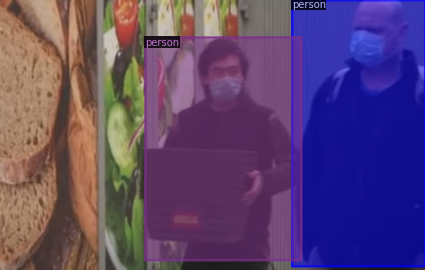

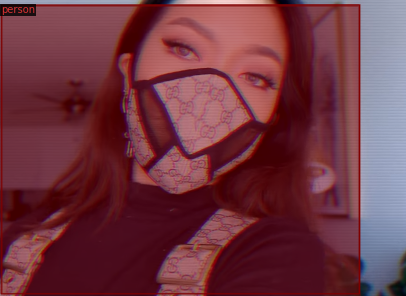

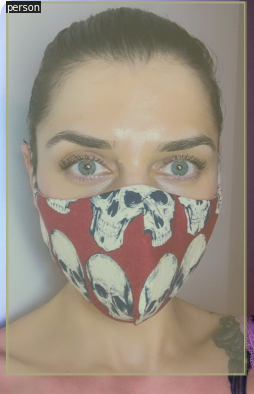

In [ ]:
for d in random.sample(dataset_dicts_all, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])